In [7]:
import re
import pandas as pd
from sklearn import set_config
from sklearn.model_selection import train_test_split
import pymorphy3

set_config(transform_output="pandas")


morph = pymorphy3.MorphAnalyzer()

def _preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def _remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def _remove_emojis(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


def _lemmatize(text):
    words = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

def preprocess_for_prediction(text):
    text = _remove_punctuation(text)
    text = _remove_emojis(text)
    text = _preprocess_text(text)
    text = _lemmatize(text)
    return text

preprocess_for_prediction("Купили эти наушники пару недель назад — звук просто потрясающий! 🎧 Но через несколько дней начали трещать на высокой громкости. Немного разочарованы 😕, хотя поначалу всё нравилось.")

'купить этот наушник пара неделя назад звук просто потрясать но через несколько день начать трещать на высокий громкость немного разочаровать хотя поначалу всё нравиться'

In [8]:
from sklearn.utils import shuffle

def load_and_prepare_data(file_path):
    data = pd.read_csv(file_path, sep=',', encoding='utf-8')
    
    data['text'] = data['text'].astype(str).apply(preprocess_for_prediction)
    data = data[data['text'].str.strip() != '']
    
    data['class'] = data['Полученный класс'].apply(lambda x: 0 if x == 1 else 1)
    
    data = shuffle(data, random_state=42).reset_index(drop=True)
    return data


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
from imblearn.over_sampling import RandomOverSampler

df = load_and_prepare_data("data/wb_reviews.csv")
print("Распределение классов до балансировки:")
print(df['class'].value_counts())

X = df['text']
y = df['class']


Распределение классов до балансировки:
class
1    36847
0    21621
Name: count, dtype: int64


In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1,1), y)
X_resampled = pd.Series(X_resampled.flatten())

print("\nРаспределение классов после балансировки (undersampling):")
print(pd.Series(y_resampled).value_counts())


Распределение классов после балансировки (undersampling):
class
0    21621
1    21621
Name: count, dtype: int64


In [11]:
df_class_0 = df[df['class'] == 0]
print(df_class_0)

                                                    name  \
1                                 Кольца набор бижутерия   
3             Зеркало напольное в полный рост на колесах   
5      Беспроводные наушники блютуз с шумоподавлением...   
6                  Жакет Пиджак женский больших размеров   
9             Комод деревянный узкий для вещей с ящиками   
...                                                  ...   
58455          Полка настенная для книг навесная из лдсп   
58458                    Обогреватель для дома настенный   
58464              Зимний комбинезон из мембранной ткани   
58465  Вешалка напольная для одежды металлическая в п...   
58467              Платье праздничное нарядное вечернее    

                                                    text  mark  \
1      при расширение кольцо лопнуть тянуть не сильно...     3   
3      очень хлипкий как детский низкий искажать отра...     2   
5      быстро садиться один наушник тихий второй пере...     2   
6      расцветк

In [12]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

In [13]:
classes = np.array(sorted(set(y_train)))
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights_dict = dict(zip(classes, class_weights))
print("\nClass Weights:", class_weights_dict)


Class Weights: {0: 1.0, 1: 1.0}


In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight=class_weights_dict),
    "SVM (Linear)": LinearSVC(class_weight=class_weights_dict),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
}
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)


    y_pred_test = pipe.predict(X_test)

    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    cm_test = confusion_matrix(y_test, y_pred_test)

    results[name] = {
        'val_report': report,
        'val_cm': cm,
        'test_report':report_test,
        'test_cm':cm
    }

    display("\n[Валидация]")
    display(classification_report(y_val, y_pred))
    display("Confusion matrix (validation):\n", cm)

    display("\n[Тест]")
    display(classification_report(y_test, y_pred_test))
    display("Confusion matrix (validation):\n", cm_test)


'\n[Валидация]'

'              precision    recall  f1-score   support\n\n           0       0.94      0.97      0.95      4324\n           1       0.97      0.93      0.95      4325\n\n    accuracy                           0.95      8649\n   macro avg       0.95      0.95      0.95      8649\nweighted avg       0.95      0.95      0.95      8649\n'

'Confusion matrix (validation):\n'

array([[4192,  132],
       [ 288, 4037]], dtype=int64)

'\n[Тест]'

'              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95      4325\n           1       0.97      0.93      0.95      4324\n\n    accuracy                           0.95      8649\n   macro avg       0.95      0.95      0.95      8649\nweighted avg       0.95      0.95      0.95      8649\n'

'Confusion matrix (validation):\n'

array([[4202,  123],
       [ 297, 4027]], dtype=int64)

'\n[Валидация]'

'              precision    recall  f1-score   support\n\n           0       0.95      0.96      0.95      4324\n           1       0.96      0.95      0.95      4325\n\n    accuracy                           0.95      8649\n   macro avg       0.95      0.95      0.95      8649\nweighted avg       0.95      0.95      0.95      8649\n'

'Confusion matrix (validation):\n'

array([[4147,  177],
       [ 233, 4092]], dtype=int64)

'\n[Тест]'

'              precision    recall  f1-score   support\n\n           0       0.95      0.96      0.96      4325\n           1       0.96      0.94      0.95      4324\n\n    accuracy                           0.95      8649\n   macro avg       0.95      0.95      0.95      8649\nweighted avg       0.95      0.95      0.95      8649\n'

'Confusion matrix (validation):\n'

array([[4172,  153],
       [ 240, 4084]], dtype=int64)

'\n[Валидация]'

'              precision    recall  f1-score   support\n\n           0       0.93      0.94      0.94      4324\n           1       0.94      0.93      0.94      4325\n\n    accuracy                           0.94      8649\n   macro avg       0.94      0.94      0.94      8649\nweighted avg       0.94      0.94      0.94      8649\n'

'Confusion matrix (validation):\n'

array([[4061,  263],
       [ 295, 4030]], dtype=int64)

'\n[Тест]'

'              precision    recall  f1-score   support\n\n           0       0.93      0.94      0.94      4325\n           1       0.94      0.93      0.94      4324\n\n    accuracy                           0.94      8649\n   macro avg       0.94      0.94      0.94      8649\nweighted avg       0.94      0.94      0.94      8649\n'

'Confusion matrix (validation):\n'

array([[4058,  267],
       [ 293, 4031]], dtype=int64)

'\n[Валидация]'

'              precision    recall  f1-score   support\n\n           0       0.93      0.95      0.94      4324\n           1       0.95      0.93      0.94      4325\n\n    accuracy                           0.94      8649\n   macro avg       0.94      0.94      0.94      8649\nweighted avg       0.94      0.94      0.94      8649\n'

'Confusion matrix (validation):\n'

array([[4119,  205],
       [ 296, 4029]], dtype=int64)

'\n[Тест]'

'              precision    recall  f1-score   support\n\n           0       0.93      0.95      0.94      4325\n           1       0.95      0.93      0.94      4324\n\n    accuracy                           0.94      8649\n   macro avg       0.94      0.94      0.94      8649\nweighted avg       0.94      0.94      0.94      8649\n'

'Confusion matrix (validation):\n'

array([[4127,  198],
       [ 287, 4037]], dtype=int64)

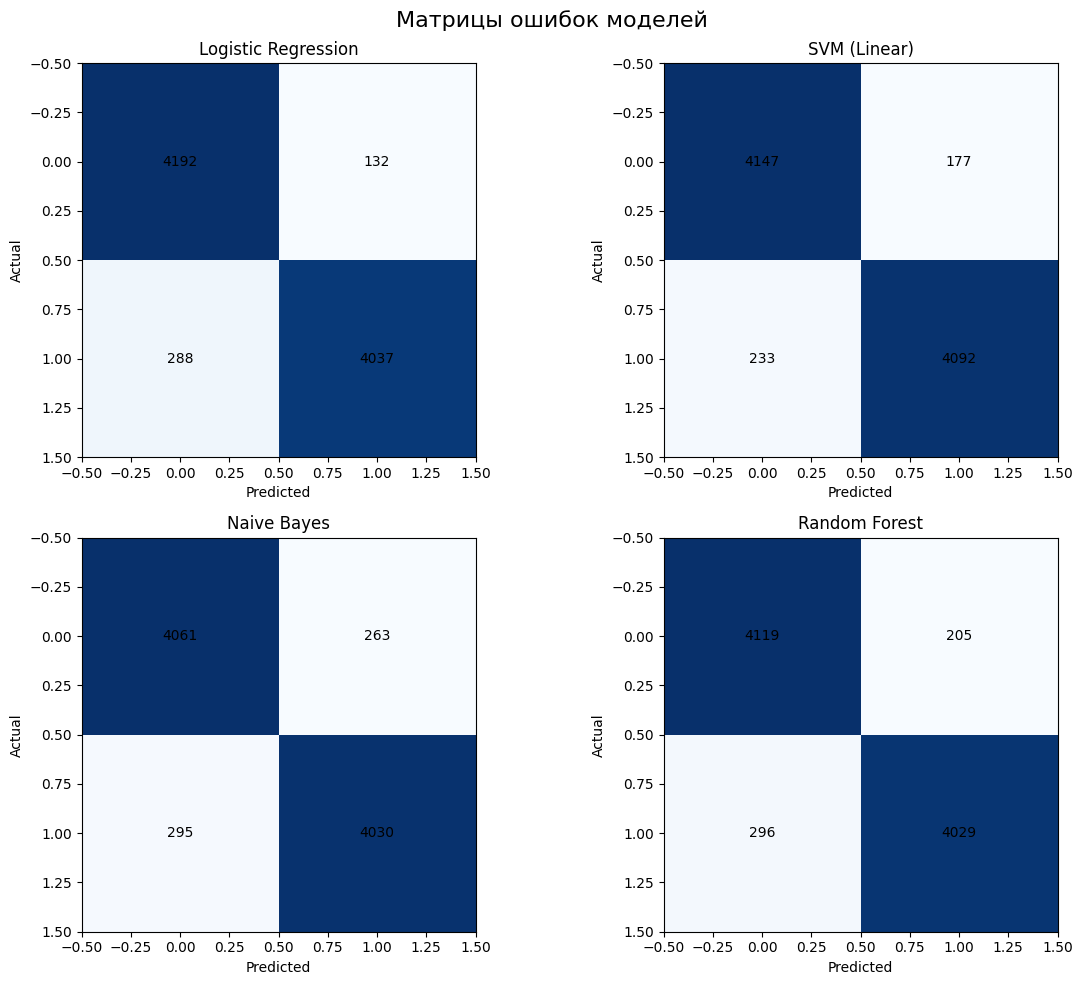

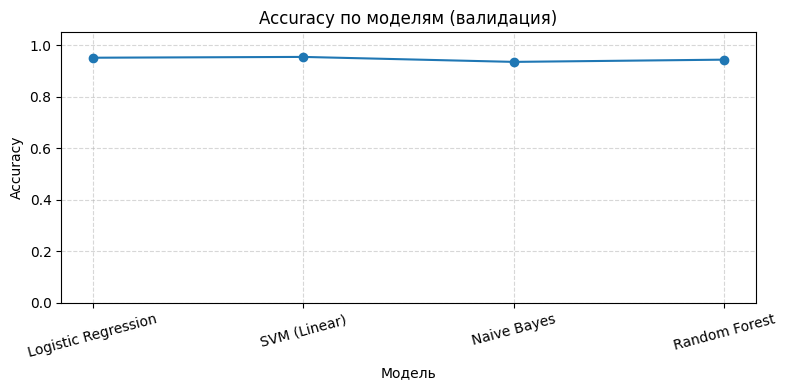

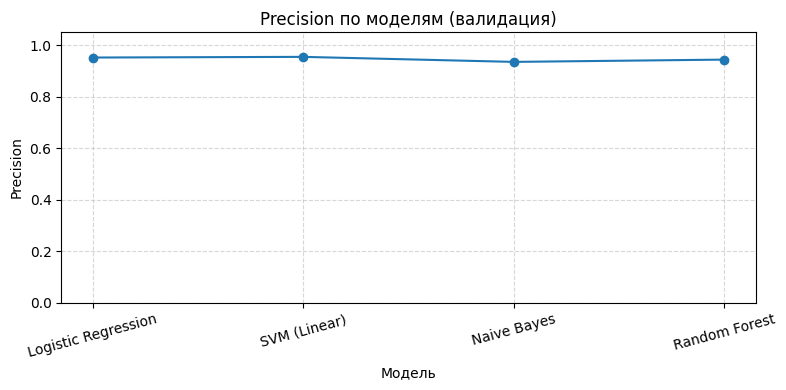

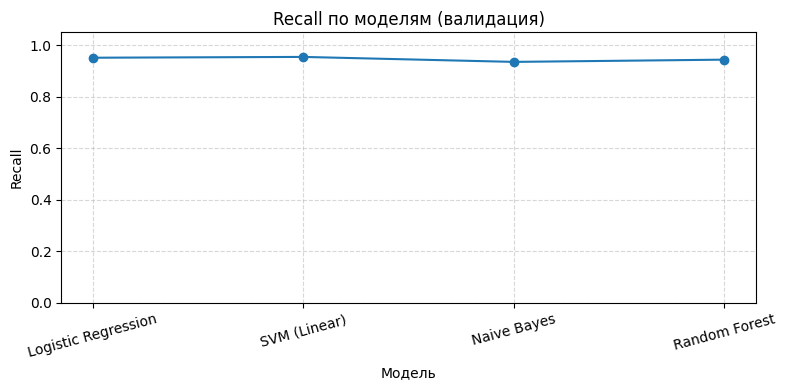

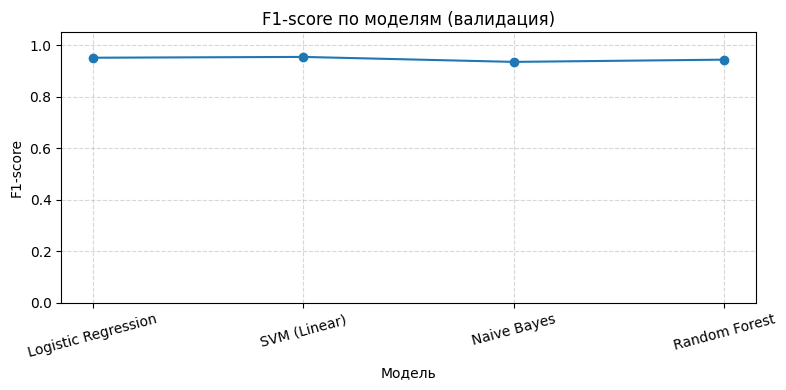

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, data) in enumerate(results.items()):
    cm = data['test_cm']
    ax = axes[i]
    im = ax.imshow(cm, cmap='Blues')

    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for (j, k), val in np.ndenumerate(cm):
        ax.text(k, j, str(val), ha='center', va='center')

fig.suptitle("Матрицы ошибок моделей", fontsize=16)
plt.tight_layout()
plt.show()

metric_names = ['accuracy', 'precision', 'recall', 'f1-score']
metrics_summary = {metric: [] for metric in metric_names}
model_names = list(results.keys())

for model in model_names:
    report = results[model]['test_report']
    metrics_summary['f1-score'].append(report['weighted avg']['f1-score'])
    metrics_summary['precision'].append(report['weighted avg']['precision'])
    metrics_summary['recall'].append(report['weighted avg']['recall'])

    acc = accuracy_score(
        y_test,
        Pipeline([('tfidf', TfidfVectorizer()), ('clf', models[model])])
        .fit(X_train, y_train).predict(X_test)
    )
    metrics_summary['accuracy'].append(acc)

for metric in metric_names:
    plt.figure(figsize=(8, 4))
    plt.plot(model_names, metrics_summary[metric], marker='o', linestyle='-')
    plt.title(f'{metric.capitalize()} по моделям (валидация)')
    plt.xlabel('Модель')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()